# Trends detection based on Bayesian method

In [1]:
import os, sys
import gc

import datetime

import numpy as np
from numpy.random import default_rng
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

In [2]:
df_ge = pd.read_csv("ge.us.txt", engine='python')
df_ge.rename(columns={'Date': 'Time'}, inplace=True)
df_ge['Time'] = pd.to_datetime(df_ge['Time'])

In [3]:
len(df_ge)

14058

In [4]:
df_old = df_ge[:1000].copy()
df = df_ge[1000:].copy()

In [5]:
df.reset_index(inplace=True, drop=True)
df

,Time,Open,High,Low,Close,Volume,OpenInt
0,1965-12-22,0.9419,0.9580,0.9419,0.9500,1669356,0
1,1965-12-23,0.9580,0.9662,0.9580,0.9662,2802131,0
2,1965-12-27,0.9662,0.9662,0.9580,0.9662,1550115,0
3,1965-12-28,0.9662,0.9742,0.9580,0.9662,1967454,0
4,1965-12-29,0.9662,0.9742,0.9662,0.9742,1180470,0
...,...,...,...,...,...,...,...
13053,2017-11-06,20.5200,20.5300,20.0800,20.1300,60641787,0
13054,2017-11-07,20.1700,20.2500,20.1200,20.2100,41622851,0
13055,2017-11-08,20.2100,20.3200,20.0700,20.1200,39672190,0
13056,2017-11-09,20.0400,20.0710,19.8500,19.9900,50831779,0


In [6]:
# estimating noise amplitude
old_sig = df_old['Close'].values

baseline_old_prediction = np.zeros(len(old_sig))
baseline_old_prediction[0] = old_sig[0]
baseline_old_prediction[1:] = old_sig[:-1]

old_sigma = mean_squared_error(old_sig, baseline_old_prediction, squared=False) # estimation of trend dispersion

# estimating trends
old_deltas = np.diff(old_sig)
min_delta = np.min(old_deltas)
max_delta = np.max(old_deltas)

# range_delta = max(-min_delta, max_delta)
range_delta = 0.3

In [7]:
sig = df['Close'].values

print(f"Length of considered signal: {len(sig)}")

Length of considered signal: 13058


In [8]:
m = 11 # number of points to approximate distribution

a = np.linspace(start=-range_delta, stop=range_delta, num=m) # different trend sizes

p = 0.5

# mu = np.sqrt(np.sum(old_deltas ** 2)/len(old_deltas)) # parameter of trend jumps transition matrix

# sigma = old_sigma # noise amplitude
sigma = 0.3

print(f"sigma={sigma:.3f} (noise amplitude)")

sigma=0.300 (noise amplitude)


In [9]:
# calculating transition matrix
K = np.zeros((m, m))

for i in range(m):
    for j in range(m):
        # K[i, j] = np.exp(-((a[i]-a[j])/mu)**2/2)
        K[i, j] =  1 # np.exp(-(a[i]/mu)**2 / 2)

K = K/np.sum(K, axis=0)
K = p * K

K_prime = K.copy()

for i in range(m):
    K[i, i] += 1 - p
    
w_prior = np.ones(len(a)) # np.exp(-(a / mu)** 2 / 2) 
w_prior = w_prior / np.sum(w_prior) # probabilities of different trend sizes

# finding equilibrium distribution for our Markov chain
num_iter = 5000
w_traj_old = np.zeros((m, num_iter))

for k in range(num_iter):
    w_traj_old[:, k] = w_prior
    w_prior = np.dot(K, w_prior)
    w_prior = w_prior / np.sum(w_prior)

In [10]:
w_prior

array([0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909])

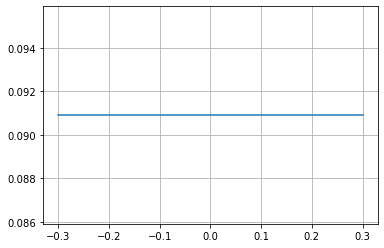

In [11]:
plt.plot(a, w_prior)
plt.grid()

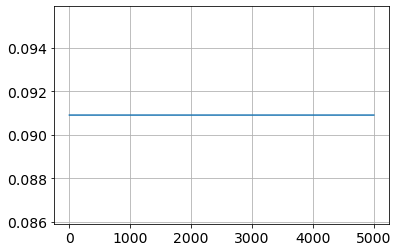

In [12]:
font = {'size': 14}
matplotlib.rc('font', **font)
    
plt.plot(w_traj_old[0, :])
plt.grid()

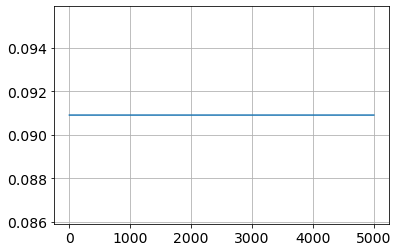

In [13]:
font = {'size': 14}
matplotlib.rc('font', **font)
    
plt.plot(w_traj_old[m // 2, :])
plt.grid()

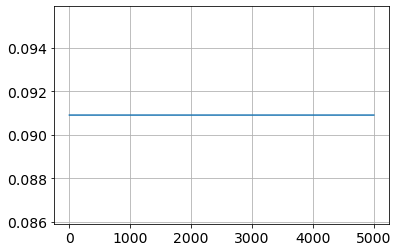

In [14]:
font = {'size': 14}
matplotlib.rc('font', **font)
    
plt.plot(w_traj_old[m // 2 - 5, :])
plt.grid()

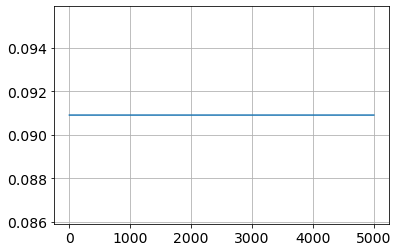

In [15]:
font = {'size': 14}
matplotlib.rc('font', **font)

plt.plot(w_traj_old[m // 2 + 5, :])
plt.grid()

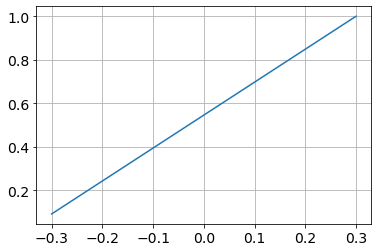

In [16]:
font = {'size': 14}
matplotlib.rc('font', **font)
    
plt.plot(a, np.cumsum(w_traj_old[:, 0]))
plt.grid()

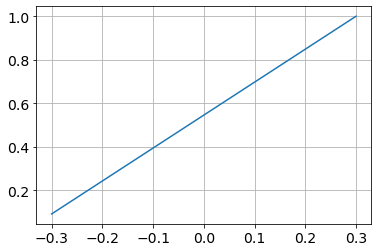

In [17]:
font = {'size': 14}
matplotlib.rc('font', **font)

plt.plot(a, np.cumsum(w_traj_old[:, num_iter - 1]))
plt.grid()

In [18]:
print(f"{datetime.datetime.now()} Started predictions")

M = 1000 # step for recalculating parameters of the model

N = len(sig)

predictions = np.zeros(N)
predictions[0] = sig[0] # let us assume we know the first signal value exactly

c = np.zeros((m, M)) # c is a matrix of p(\delta x_k, \ldots, \delta x_n \mid a_j)
ps = np.zeros(m) # ps is a row of p(\delta_x \mid a_j) for j = 1,...,m 
p_jump = np.zeros(M)

p_arr = np.zeros(N // M + 1)
p_arr[0] = p

w = w_prior

w_traj = np.zeros((m, N))
w_traj[:, 0] = w

w_traj_after = np.zeros((m, N))
w_traj_after[:, 0] = w

for k in range(1, N):
    
    # prediction
    predictions[k] = sig[k - 1] + np.dot(w, a) # or, if we want to predict delta, simply np.dot(w, a)
    
    # Bayesian recalculation step
    delta_x = sig[k] - sig[k-1]
    
    for i in range(m):
        w[i] = w[i] * norm.pdf(delta_x, loc=a[i], scale=sigma)
    
    w = w / np.sum(w)
    
    #if np.sum(np.isnan(w)) > 0:
    #    print(f"k={k}, w={w}")
    
    w_traj[:, k] = w
    
    # markov chain transition due to possible trend   
    w = np.dot(K, w)
    w = w / np.sum(w) # norming, to avoid numerical effects due to finite precision
    
    w_traj_after[:, k] = w
    
    """
    if k % M == 0: # recalculate parameters of the model

        for j in range(m):
            delta_x = sig[k] - sig[k-1]
            c[j, M-1] = norm.pdf(delta_x, loc=a[j], scale=sigma)
        c[:, M-1] = c[:, M-1] / np.sum(c[:, M-1])
        
        for i in range(1, M):
            delta_x = sig[k - i] - sig[k - i - 1]
            for j in range(m):
                ps[j] = norm.pdf(delta_x, loc=a[j], scale=sigma)
            c[:, M-i-1] = np.dot(c[:, M-i], K) * ps
            c[:, M-i-1] = c[:, M-i-1] / np.sum(c[:, M-i-1])
            
        for i in range(M):
            j = i + (k - M)
            nom = np.dot(np.dot(c[:, i], K_prime), w_traj[:, j])
            den = np.dot(np.dot(c[:, i], K), w_traj[:, j])
            p_jump[i] = nom/den
        
        p = np.mean(p_jump)
        print(f"After step {k} p is {p}")
        p_arr[k // M] = p
        
        weights = c * w_traj_after[:, k - M : k]
        weights = weights / np.sum(weights, axis=0)
        
        f = np.mean(weights, axis=1)
        
        assert len(f) == m
        
        # recalculate K
        for i in range(m):
            for j in range(m):                   
                K[i, j] = f[i]

        K = K/np.sum(K, axis=0)
        K = p * K

        K_prime = K.copy()

        for i in range(m):
            K[i, i] += 1 - p
    """
    
    if k % 1000 == 0:
        print(f"{datetime.datetime.now()} Processed {k} points of signal")
        
print(f"{datetime.datetime.now()} Performed predictions")

2022-01-21 16:44:57.293767 Started predictions
2022-01-21 16:44:58.492395 Processed 1000 points of signal
2022-01-21 16:44:59.746433 Processed 2000 points of signal
2022-01-21 16:45:00.985507 Processed 3000 points of signal
2022-01-21 16:45:02.074267 Processed 4000 points of signal
2022-01-21 16:45:03.224513 Processed 5000 points of signal
2022-01-21 16:45:04.412506 Processed 6000 points of signal
2022-01-21 16:45:05.578881 Processed 7000 points of signal
2022-01-21 16:45:06.745170 Processed 8000 points of signal
2022-01-21 16:45:07.863891 Processed 9000 points of signal
2022-01-21 16:45:08.951266 Processed 10000 points of signal
2022-01-21 16:45:10.040782 Processed 11000 points of signal
2022-01-21 16:45:11.146885 Processed 12000 points of signal
2022-01-21 16:45:12.219772 Processed 13000 points of signal
2022-01-21 16:45:12.282024 Performed predictions


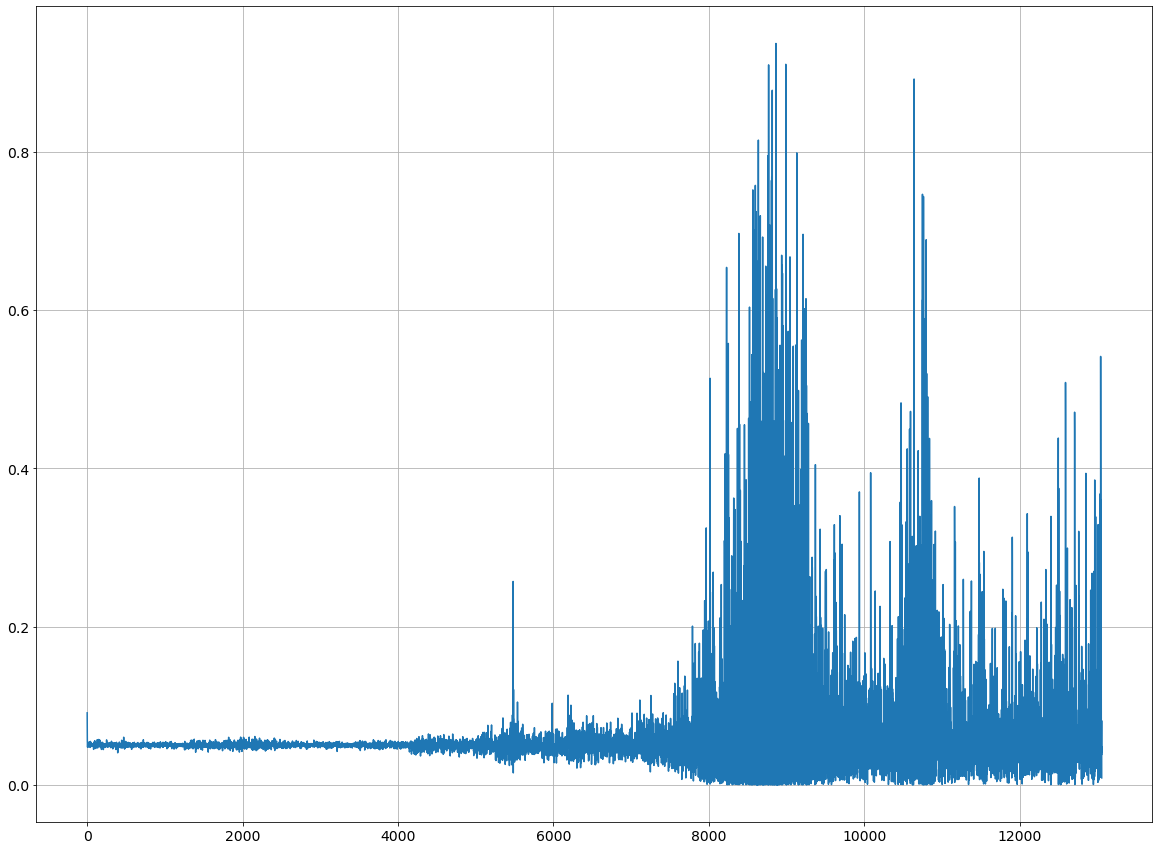

In [19]:
font = {'size': 14}
matplotlib.rc('font', **font)
    
plt.subplots(1, 1, figsize=(20, 15))
plt.plot(w_traj[0, :], markersize=3)
plt.grid()

In [20]:
np.sum(np.isnan(w))

0

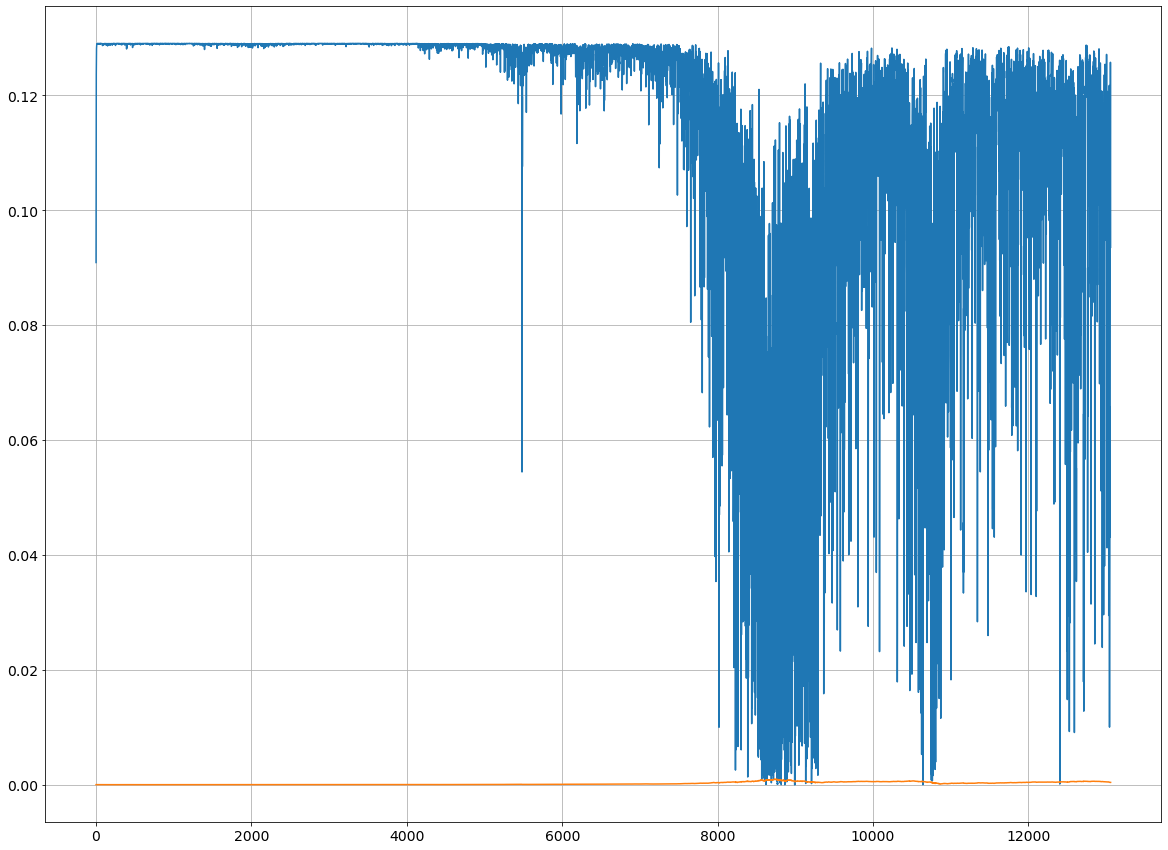

In [21]:
font = {'size': 14}
matplotlib.rc('font', **font)
    
plt.subplots(1, 1, figsize=(20, 15))
plt.plot(w_traj[m//2, :], markersize=3)
plt.plot(sig/50000)
plt.grid()

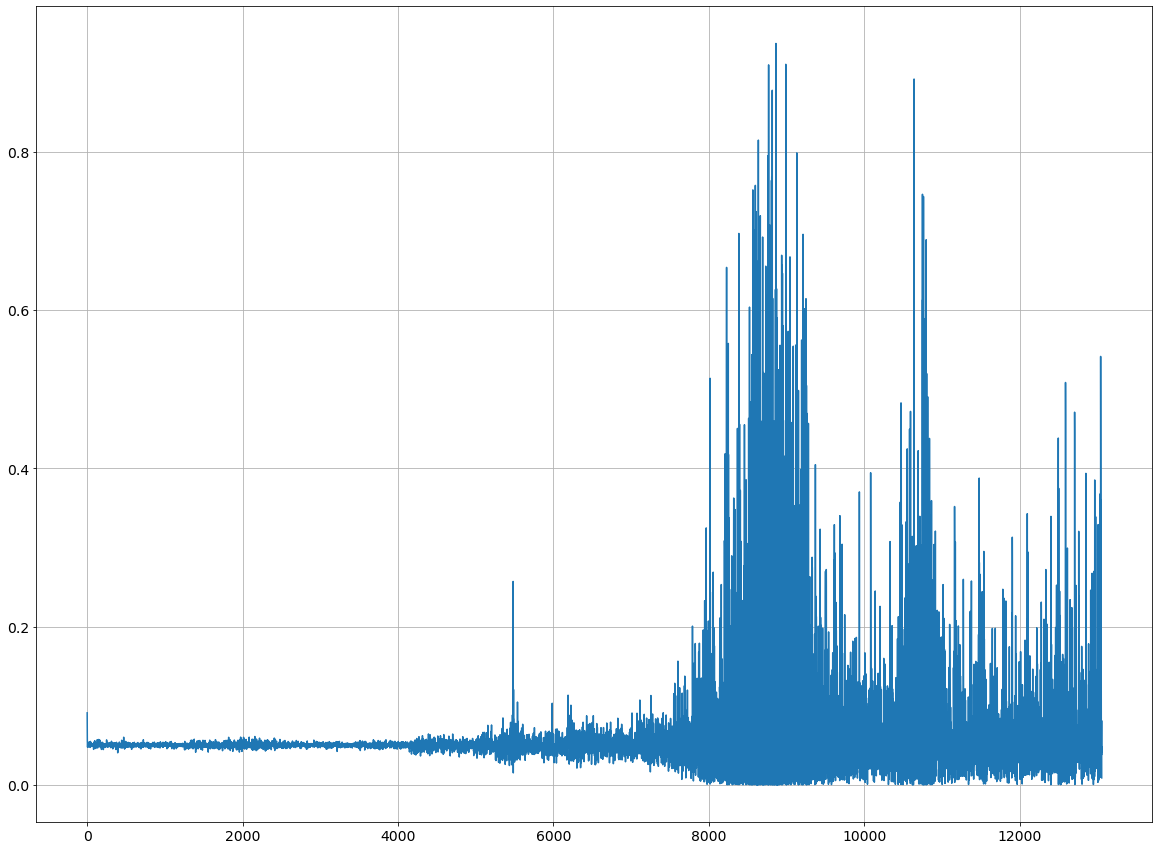

In [22]:
font = {'size': 14}
matplotlib.rc('font', **font)
    
plt.subplots(1, 1, figsize=(20, 15))
plt.plot(w_traj[m//2 - 5, :], markersize=3)
plt.grid()

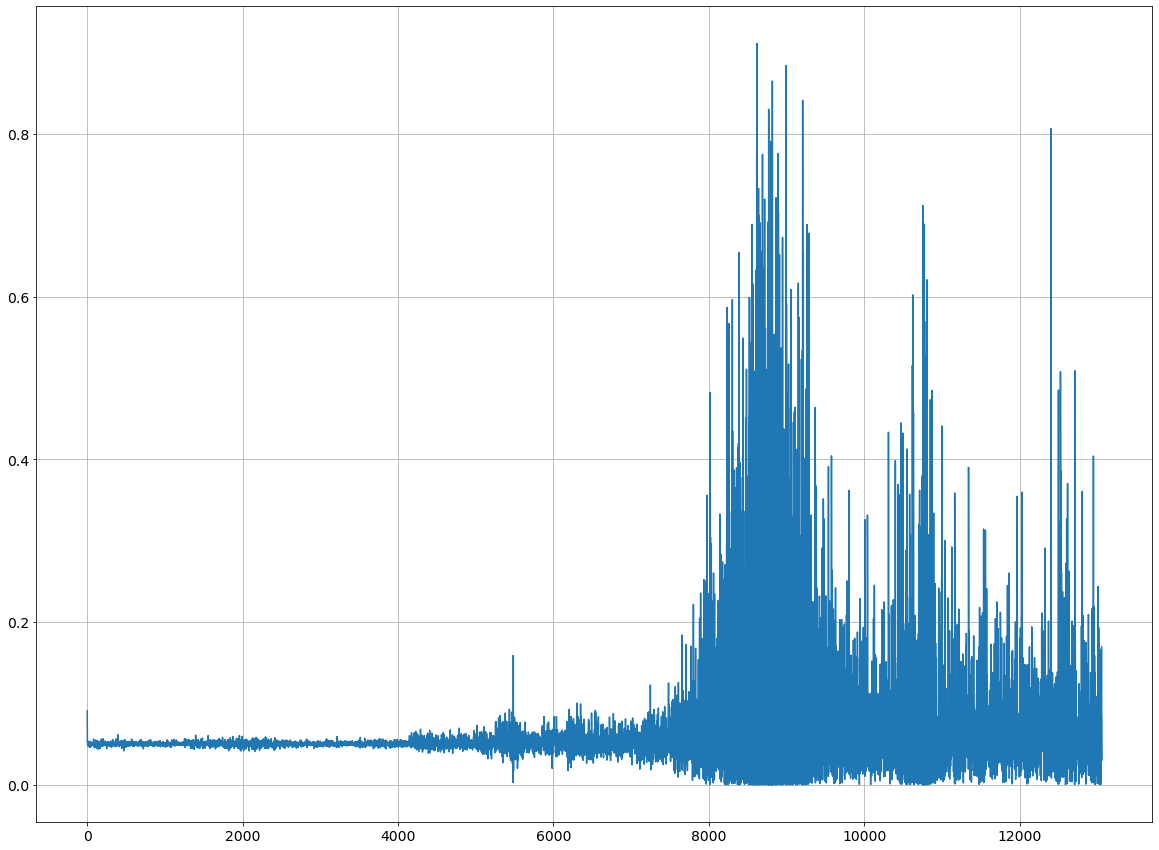

In [23]:
font = {'size': 14}
matplotlib.rc('font', **font)
    
plt.subplots(1, 1, figsize=(20, 15))
plt.plot(w_traj[m//2 + 5, :], markersize=3)
plt.grid()

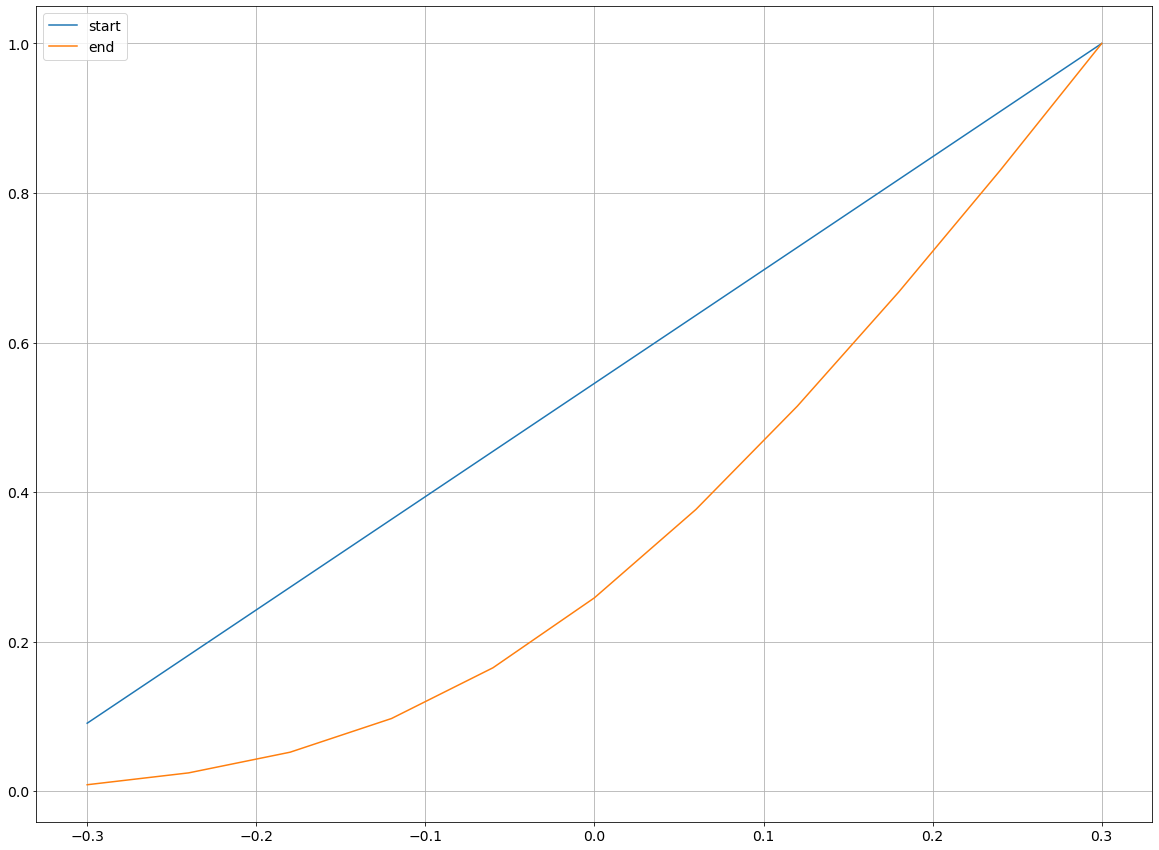

In [24]:
font = {'size': 14}
matplotlib.rc('font', **font)
    
plt.subplots(1, 1, figsize=(20, 15))
plt.plot(a, np.cumsum(w_traj[:, 0]), label='start')
plt.plot(a, np.cumsum(w_traj[:, N - 1]), label='end')
# plt.plot(a, np.cumsum(w_traj_old[:, 0]), label='old')
plt.grid()
plt.legend()

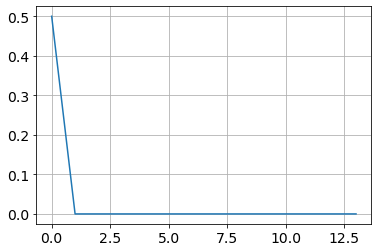

In [25]:
plt.plot(p_arr)
plt.grid()

In [26]:
baseline_prediction = np.zeros(len(sig))
baseline_prediction[0] = sig[0]
baseline_prediction[1:] = sig[:-1]

error_baseline = mean_squared_error(sig, baseline_prediction, squared=False)
error_bayesian = mean_squared_error(sig, predictions, squared=False)

print(f"Baseline error: {error_baseline:.3f}")
print(f"Bayesian error: {error_bayesian:.3f}")

Baseline error: 0.287
Bayesian error: 0.289


In [27]:
w_traj[:, N - 1]

array([0.00862233, 0.01586425, 0.02764508, 0.04507171, 0.06786556,
       0.09356026, 0.11814581, 0.1382088 , 0.15270655, 0.16269125,
       0.16961839])

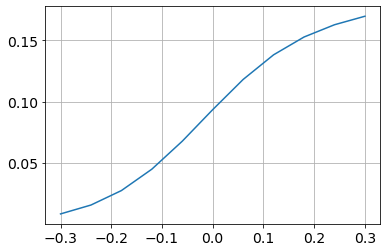

In [28]:
plt.plot(a, w_traj[:, N - 1])
plt.grid()